# Absolutdata Assignment - By - Anurag Maheshwari
## Problem Statement - 
## 1. Analyze hemoglobin levels and genetic history to predict blood pressure abnormalities.
## 2. Assess the impact of factors other than genetic and haemoglobin.

## Background Information :
### 1. Hemoglobin level is positively associated with blood pressure
### 2. Genetic causes are also prominent in some individuals

## Approach
#### A. Reading and Preparing Data 
    1. Preliminary Checks - Missing Value, Imbalanced Data, Outliers, Duplicate records
    2. Prepare Data by treating all the mentioned checks above.
#### B. Data Understanding - EDA
    1. Correlation Matrix
    2. Univariate Analysis
    3. Bivariate Analysis
#### C. Modelling 
    1. Base Model Performance
    2. Hyperparameter Tuning 
    3. Model Comparison
#### D. Model Evaluation and Comparison (Accuracy, Precision and Recall)

### Importing Libraries

In [1]:
import os, types
import io, requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from timeit import default_timer as timer
import datetime as dt
import pickle

# sklearn functions
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as gbm

# optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

# error metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import norm

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss


import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# imputation
from impyute.imputation.cs import fast_knn

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## A. Reading and Preparing Data

In [2]:
url = "https://drive.google.com/file/d/1rMCngCnhu0EGpao0nkQTsP8p49a143y_/view?usp=sharing"
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head(10)

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,0,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
5,6,0,11.64,0.54,23,48,0,NaN,1,27042,7513,NaN,3,0,0
6,7,1,11.69,0.75,43,41,1,1.0,0,38369,32967,206.0,3,1,1
7,8,0,12.70,0.41,48,20,0,NaN,0,29781,26749,134.0,2,0,0
8,9,0,10.88,0.68,72,44,0,NaN,0,814,9607,99.0,3,0,0
9,10,1,14.56,0.61,40,44,0,NaN,0,1278,12715,95.0,2,0,0


### 1. Preliminary Checks

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
Patient_Number                   2000 non-null int64
Blood_Pressure_Abnormality       2000 non-null int64
Level_of_Hemoglobin              2000 non-null float64
Genetic_Pedigree_Coefficient     1908 non-null float64
Age                              2000 non-null int64
BMI                              2000 non-null int64
Sex                              2000 non-null int64
Pregnancy                        442 non-null float64
Smoking                          2000 non-null int64
Physical_activity                2000 non-null int64
salt_content_in_the_diet         2000 non-null int64
alcohol_consumption_per_day      1758 non-null float64
Level_of_Stress                  2000 non-null int64
Chronic_kidney_disease           2000 non-null int64
Adrenal_and_thyroid_disorders    2000 non-null int64
dtypes: float64(4), int64(11)
memory usage: 234.5 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Patient_Number,2000.0,1000.500000,577.494589,1.0,500.7500,1000.50,1500.250,2000.00
Blood_Pressure_Abnormality,2000.0,0.493500,0.500083,0.0,0.0000,0.00,1.000,1.00
Level_of_Hemoglobin,2000.0,11.710035,2.186701,8.1,10.1475,11.33,12.945,17.56
Genetic_Pedigree_Coefficient,1908.0,0.494817,0.291736,0.0,0.2400,0.49,0.740,1.00
Age,2000.0,46.558500,17.107832,18.0,32.0000,46.00,62.000,75.00
BMI,2000.0,30.081500,11.761208,10.0,20.0000,30.00,40.000,50.00
Sex,2000.0,0.496000,0.500109,0.0,0.0000,0.00,1.000,1.00
Pregnancy,442.0,0.450226,0.498080,0.0,0.0000,0.00,1.000,1.00
Smoking,2000.0,0.509500,0.500035,0.0,0.0000,1.00,1.000,1.00
Physical_activity,2000.0,25254.424500,14015.439623,628.0,13605.7500,25353.00,37382.250,49980.00


In [5]:
# Check if there are any missing datasets
df.isnull().sum()

Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient       92
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day       242
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64

In [6]:
# Check for duplicates
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders


- No duplicate records

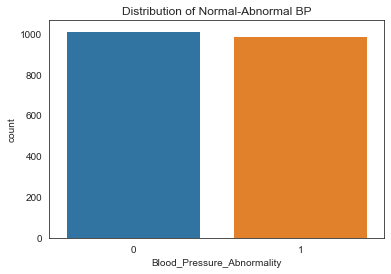

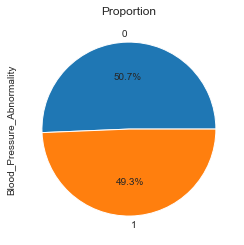

In [7]:
# Check for Bias in Target Variable
with sns.axes_style("white"):
    sns.countplot(x = "Blood_Pressure_Abnormality", data = df)
    plt.title("Distribution of Normal-Abnormal BP")
    plt.show()
    df.Blood_Pressure_Abnormality.value_counts().plot.pie(autopct = "%.1f%%")
    plt.title("Proportion")
    plt.show()

- Target variable is equally balanced.

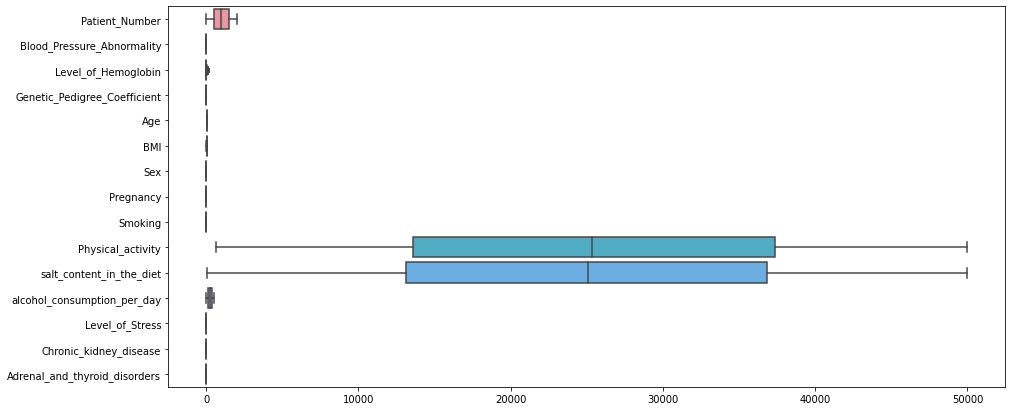

In [8]:
# Check for Outliers
f,ax=plt.subplots(figsize=(15,7))
sns.boxplot(data=df, orient='h');

- No Outliers detected

## 2. Treating NULL values

In [9]:
## Pregnancy (~78%) - It is considered that out of 992 females, 45% are pregenant
# The other 55% are considered as not-pregnant and NaN can be replaced by 0 for those rows
# The male data points can also be replaced by 0 
df['Pregnancy'] = df['Pregnancy'].fillna(0)

In [10]:
## Genetic_Pedigree_Coefficient (~5%) 
## alcohol_consumption_per_day (~12%)
# Both can be impute using KNN as there are no outliers in both datasets and it can be much more accurate than the mean, median or most frequent imputation methods
colnames = df.columns
df=pd.DataFrame(fast_knn(df.values, k=30))
df.columns = colnames

## B. EDA

### 1. Correlation Matrix

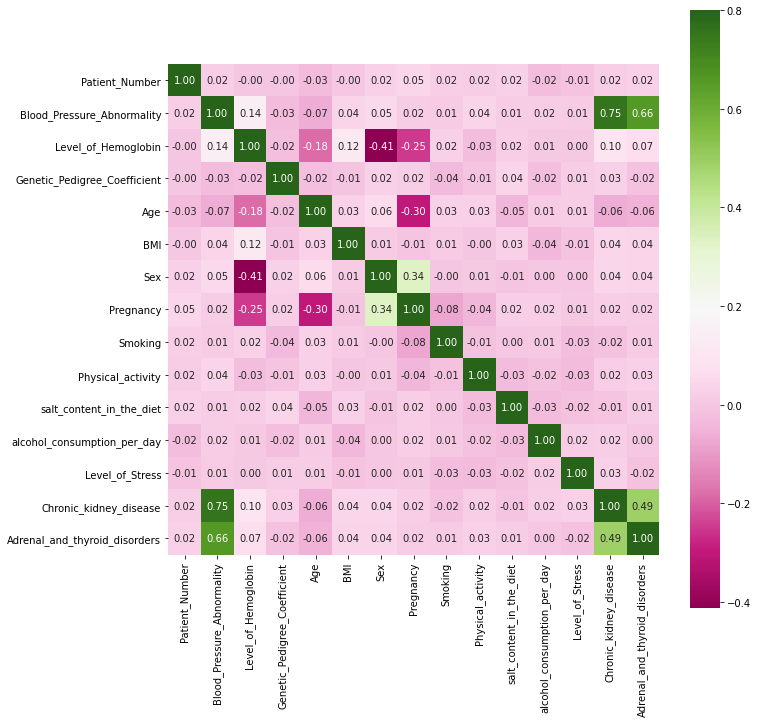

In [11]:
f, ax = plt.subplots(figsize=(11,11))
sns.heatmap(df.corr(), vmax=.8, square=True, annot=True, fmt='.2f',cmap="PiYG");

- Instead of Haemoglobin and Genetic Coefficients, BP abnormality sees high correlation with CHronic kidney diseases and adrenal and thyroid disrorder.
- Chronic kidner disease and adrenal/thyroid disroder shows high multicollinearity
- Sex, pregnancy and Age shows siginificant negative correlation with the levels of Haemoglobin which potentially could be use in feature engineering for BP abnormalities

### 2. Univariate Analysis

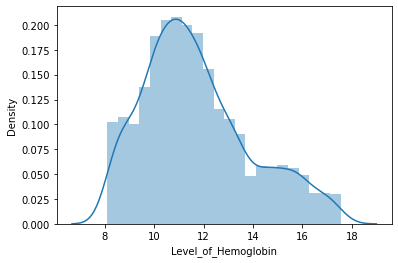

In [12]:
sns.distplot(df['Level_of_Hemoglobin']);
# - Level of Haemoglobin are positively skewed.

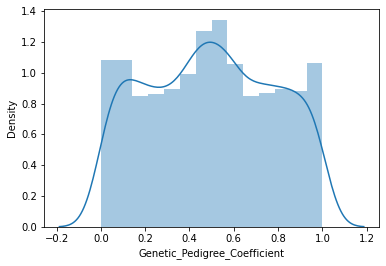

In [13]:
sns.distplot(df['Genetic_Pedigree_Coefficient']);
# - At 0 and 1 have 2 highs

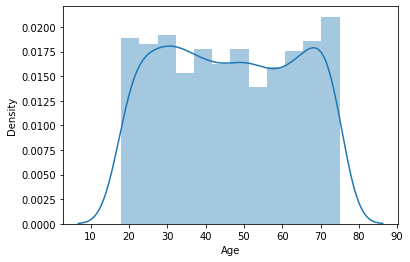

In [14]:
sns.distplot(df['Age']);
# - Age is almost equally distributed showing all age group (20-75)in the dataset 

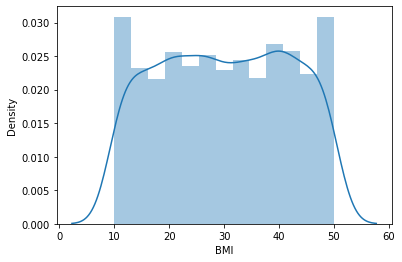

In [15]:
sns.distplot(df['BMI']);
# - Have two extremes at 10 and 50 

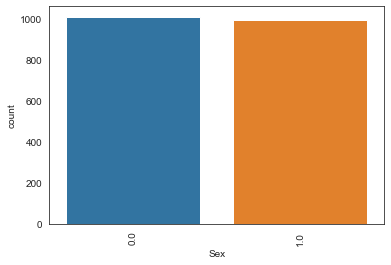

In [16]:
# Sex
with sns.axes_style("white"):
    sns.countplot(x = "Sex", data = df)
    plt.xticks(rotation = 90)
    plt.show()

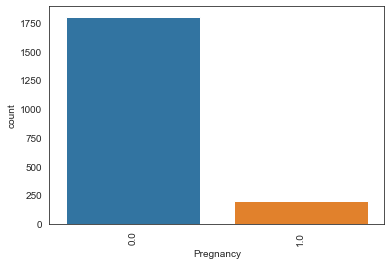

In [17]:
# Pregnancy
with sns.axes_style("white"):
    sns.countplot(x = "Pregnancy", data = df)
    plt.xticks(rotation = 90)
    plt.show()

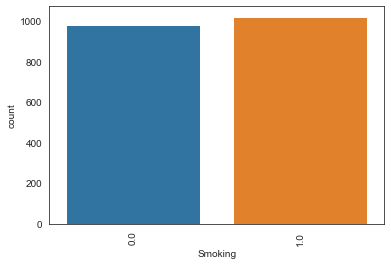

In [18]:
# Smoking
with sns.axes_style("white"):
    sns.countplot(x = "Smoking", data = df)
    plt.xticks(rotation = 90)
    plt.show()

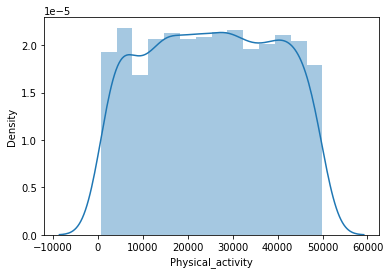

In [19]:
sns.distplot(df['Physical_activity']);

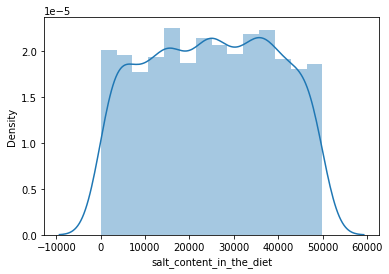

In [20]:
sns.distplot(df['salt_content_in_the_diet']);

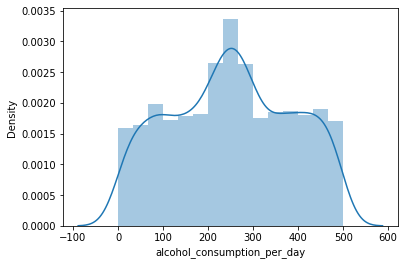

In [21]:
sns.distplot(df['alcohol_consumption_per_day']);

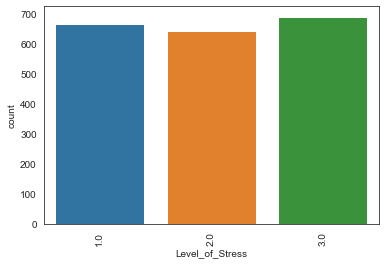

In [22]:
# Level_of_Stress
with sns.axes_style("white"):
    sns.countplot(x = "Level_of_Stress", data = df)
    plt.xticks(rotation = 90)
    plt.show()

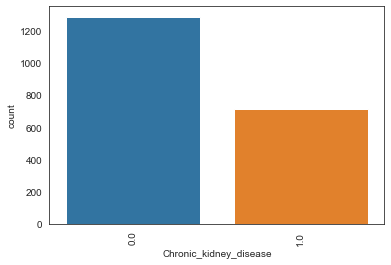

In [23]:
# Chronic_kidney_disease
with sns.axes_style("white"):
    sns.countplot(x = "Chronic_kidney_disease", data = df)
    plt.xticks(rotation = 90)
    plt.show()

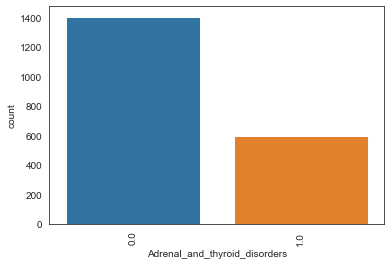

In [24]:
# Adrenal_and_thyroid_disorders
with sns.axes_style("white"):
    sns.countplot(x = "Adrenal_and_thyroid_disorders", data = df)
    plt.xticks(rotation = 90)
    plt.show()

### 3. Bivariate Analysis

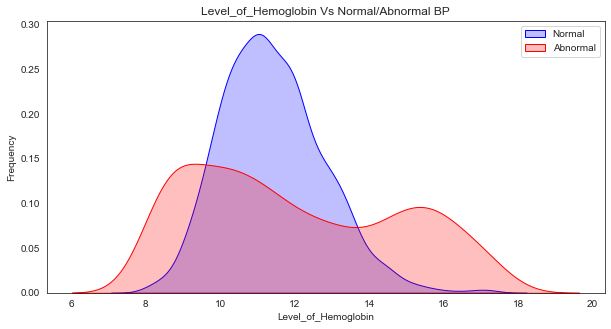

In [25]:
# Level_of_Hemoglobin
with sns.axes_style("white"):
    fig = plt.figure(figsize=(10,5))
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 0), "Level_of_Hemoglobin"], color = "b", shade = True,label = "Normal")
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 1), "Level_of_Hemoglobin"], color = "r", shade = True, label = "Abnormal")
    ax.legend(loc="upper right")
    ax.set_xlabel("Level_of_Hemoglobin")
    ax.set_ylabel("Frequency")
    ax.set_title("Level_of_Hemoglobin Vs Normal/Abnormal BP")
    plt.show()

- There is clear distinction of normality in the BP using Haemoglobion distribution. Hence the background information is correct.

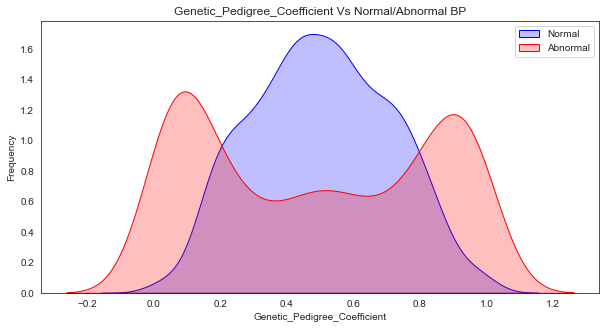

In [26]:
# Genetic_Pedigree_Coefficient
with sns.axes_style("white"):
    fig = plt.figure(figsize=(10,5))
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 0), "Genetic_Pedigree_Coefficient"], color = "b", shade = True,label = "Normal")
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 1), "Genetic_Pedigree_Coefficient"], color = "r", shade = True, label = "Abnormal")
    ax.legend(loc="upper right")
    ax.set_xlabel("Genetic_Pedigree_Coefficient")
    ax.set_ylabel("Frequency")
    ax.set_title("Genetic_Pedigree_Coefficient Vs Normal/Abnormal BP")
    plt.show()

- There is clear distinction of normality in the BP using Genetic_Pedigree_Coefficient distribution. Hence the second background information is correct.

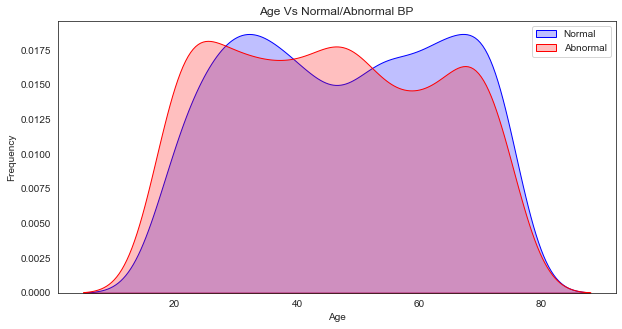

In [27]:
# Age
with sns.axes_style("white"):
    fig = plt.figure(figsize=(10,5))
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 0), "Age"], color = "b", shade = True,label = "Normal")
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 1), "Age"], color = "r", shade = True, label = "Abnormal")
    ax.legend(loc="upper right")
    ax.set_xlabel("Age")
    ax.set_ylabel("Frequency")
    ax.set_title("Age Vs Normal/Abnormal BP")
    plt.show()

- No clear distinction in terms of age

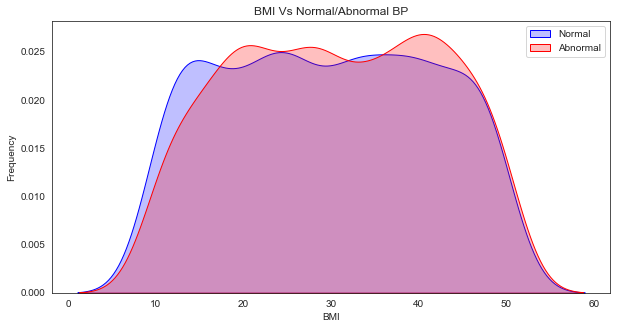

In [28]:
# BMI
with sns.axes_style("white"):
    fig = plt.figure(figsize=(10,5))
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 0), "BMI"], color = "b", shade = True,label = "Normal")
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 1), "BMI"], color = "r", shade = True, label = "Abnormal")
    ax.legend(loc="upper right")
    ax.set_xlabel("BMI")
    ax.set_ylabel("Frequency")
    ax.set_title("BMI Vs Normal/Abnormal BP")
    plt.show()

- No clear distinction in terms of BMI

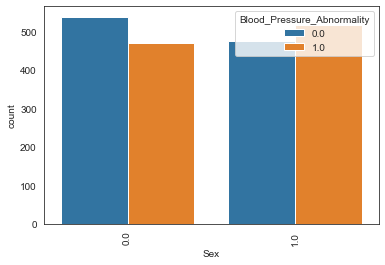

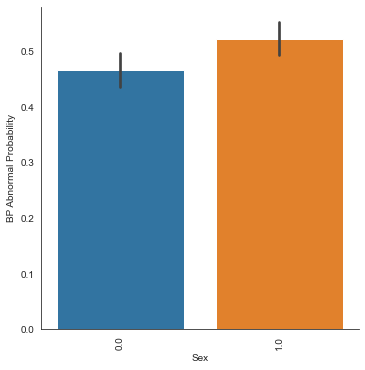

In [29]:
# Sex
with sns.axes_style("white"):
    sns.countplot(x = "Sex",hue = "Blood_Pressure_Abnormality", data = df)
    plt.xticks(rotation = 90)
    plt.show()
    sns.catplot(x = "Sex", y = "Blood_Pressure_Abnormality", data = df, kind = "bar", height = 5)
    plt.ylabel("BP Abnormal Probability")
    plt.xticks(rotation = 90)
    plt.show()

- Both Probabilites are very close for Sex. Seems not a significant factor

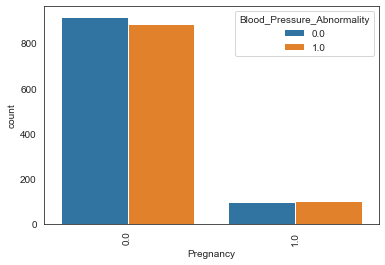

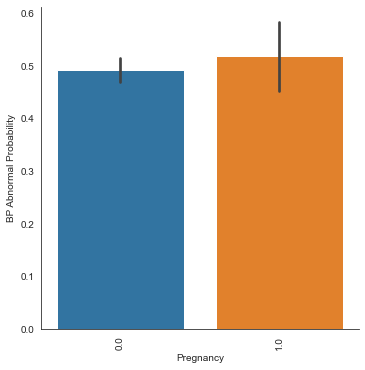

In [30]:
# Pregnancy
with sns.axes_style("white"):
    sns.countplot(x = "Pregnancy",hue = "Blood_Pressure_Abnormality", data = df)
    plt.xticks(rotation = 90)
    plt.show()
    sns.catplot(x = "Pregnancy", y = "Blood_Pressure_Abnormality", data = df, kind = "bar", height = 5)
    plt.ylabel("BP Abnormal Probability")
    plt.xticks(rotation = 90)
    plt.show()

- Both Probabilites are very close for Pregnancy. Seems not a significant factor

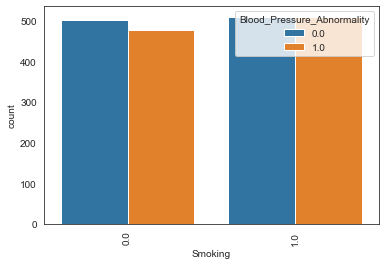

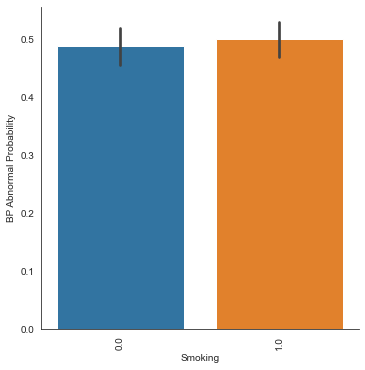

In [31]:
# Smoking
with sns.axes_style("white"):
    sns.countplot(x = "Smoking",hue = "Blood_Pressure_Abnormality", data = df)
    plt.xticks(rotation = 90)
    plt.show()
    sns.catplot(x = "Smoking", y = "Blood_Pressure_Abnormality", data = df, kind = "bar", height = 5)
    plt.ylabel("BP Abnormal Probability")
    plt.xticks(rotation = 90)
    plt.show()

- Both Probabilites are very close for Pregnancy. Seems not a significant factor

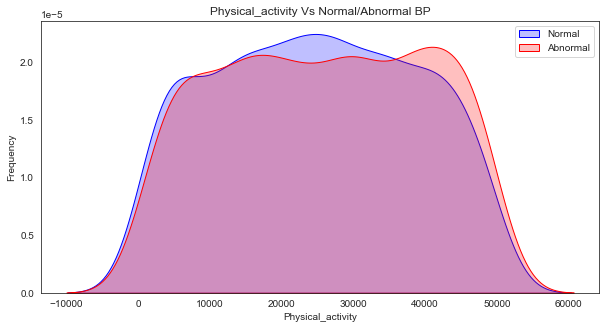

In [32]:
# Physical_activity
with sns.axes_style("white"):
    fig = plt.figure(figsize=(10,5))
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 0), "Physical_activity"], color = "b", shade = True,label = "Normal")
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 1), "Physical_activity"], color = "r", shade = True, label = "Abnormal")
    ax.legend(loc="upper right")
    ax.set_xlabel("Physical_activity")
    ax.set_ylabel("Frequency")
    ax.set_title("Physical_activity Vs Normal/Abnormal BP")
    plt.show()

- Could be driving factor for BP but not so significant

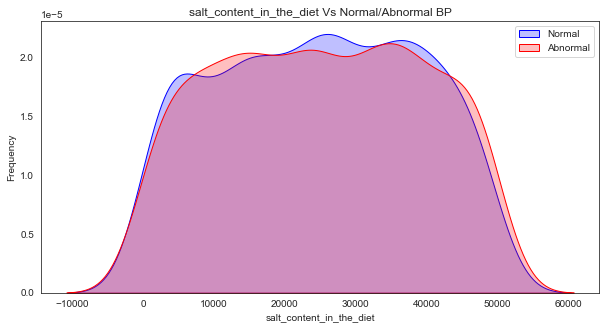

In [33]:
# salt_content_in_the_diet
with sns.axes_style("white"):
    fig = plt.figure(figsize=(10,5))
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 0), "salt_content_in_the_diet"], color = "b", shade = True,label = "Normal")
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 1), "salt_content_in_the_diet"], color = "r", shade = True, label = "Abnormal")
    ax.legend(loc="upper right")
    ax.set_xlabel("salt_content_in_the_diet")
    ax.set_ylabel("Frequency")
    ax.set_title("salt_content_in_the_diet Vs Normal/Abnormal BP")
    plt.show()

- No clear distinction in terms of salt_content_in_the_diet except for some extreme values

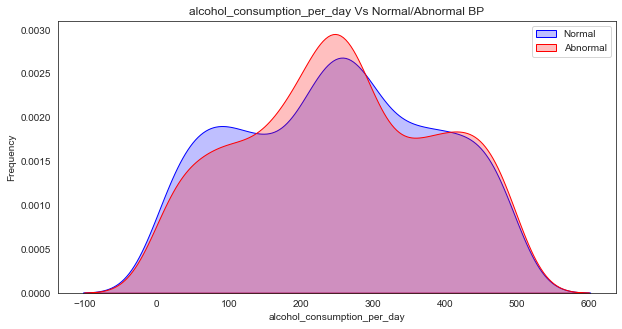

In [34]:
# alcohol_consumption_per_day
with sns.axes_style("white"):
    fig = plt.figure(figsize=(10,5))
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 0), "alcohol_consumption_per_day"], color = "b", shade = True,label = "Normal")
    ax = sns.kdeplot(df.loc[(df.Blood_Pressure_Abnormality == 1), "alcohol_consumption_per_day"], color = "r", shade = True, label = "Abnormal")
    ax.legend(loc="upper right")
    ax.set_xlabel("alcohol_consumption_per_day")
    ax.set_ylabel("Frequency")
    ax.set_title("alcohol_consumption_per_day Vs Normal/Abnormal BP")
    plt.show()

- Possibly could be a driving factor for the BP.

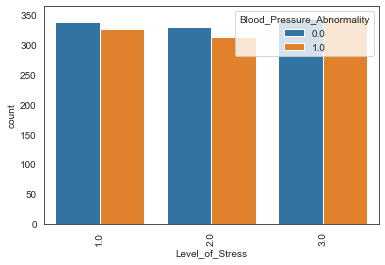

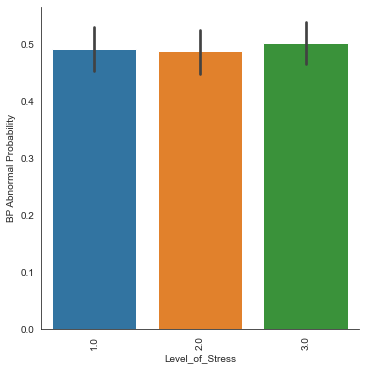

In [35]:
# Level_of_Stress
with sns.axes_style("white"):
    sns.countplot(x = "Level_of_Stress",hue = "Blood_Pressure_Abnormality", data = df)
    plt.xticks(rotation = 90)
    plt.show()
    sns.catplot(x = "Level_of_Stress", y = "Blood_Pressure_Abnormality", data = df, kind = "bar", height = 5)
    plt.ylabel("BP Abnormal Probability")
    plt.xticks(rotation = 90)
    plt.show()

- Both Probabilites are very close for level of stress. Seems not a significant factor

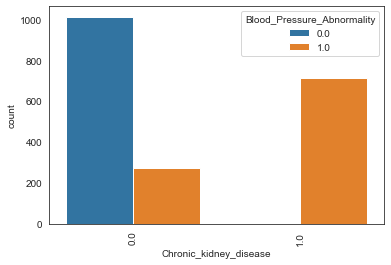

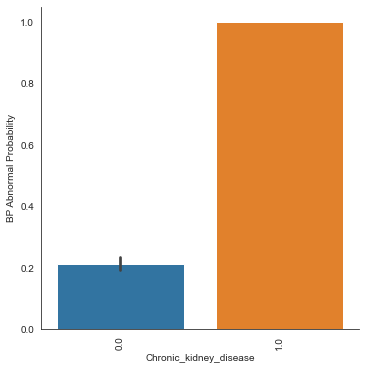

In [36]:
# Chronic_kidney_disease
with sns.axes_style("white"):
    sns.countplot(x = "Chronic_kidney_disease",hue = "Blood_Pressure_Abnormality", data = df)
    plt.xticks(rotation = 90)
    plt.show()
    sns.catplot(x = "Chronic_kidney_disease", y = "Blood_Pressure_Abnormality", data = df, kind = "bar", height = 5)
    plt.ylabel("BP Abnormal Probability")
    plt.xticks(rotation = 90)
    plt.show()

- Significant difference in the Probabilites. Chronic_kidney_disease could be a significant driving factor for the BP estimation

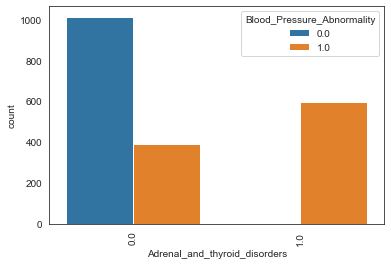

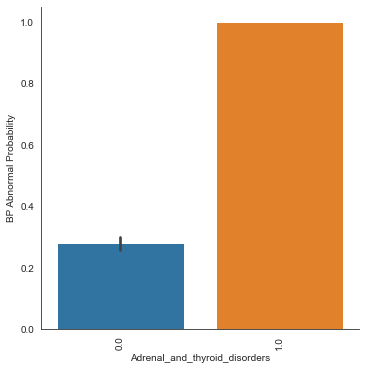

In [37]:
# Adrenal_and_thyroid_disorders
with sns.axes_style("white"):
    sns.countplot(x = "Adrenal_and_thyroid_disorders",hue = "Blood_Pressure_Abnormality", data = df)
    plt.xticks(rotation = 90)
    plt.show()
    sns.catplot(x = "Adrenal_and_thyroid_disorders", y = "Blood_Pressure_Abnormality", data = df, kind = "bar", height = 5)
    plt.ylabel("BP Abnormal Probability")
    plt.xticks(rotation = 90)
    plt.show()

- Significant difference in the Probabilites. Adrenal_and_thyroid_disorders could be a significant driving factor for the BP estimation

### Final analysis from EDA:
#### High Significant Variables : Level_of_Hemoglobin, Genetic_Pedigree_Coefficient, Chronic_kidney_disease, Adrenal_and_thyroid_disorders
#### Med Significant Variables : Age, Physical_activity, alcohol_consumption_per_day,
#### Low/No Significant Variables : BMI, Sex, Pregnancy, Smoking, salt_content_in_the_diet, Level_of_Stress

## C. Modelling 

#### As mentioned in the problem statement, we will consider only the levels of haemoglobin and the genetic history to predict Abnormality in the BP

In [38]:
X = df[['Level_of_Hemoglobin','Genetic_Pedigree_Coefficient']]
y = df[['Blood_Pressure_Abnormality']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(1400, 2) (600, 2) (1400, 1) (600, 1)


### 1. Base Model Performance

### - Logistic Regression

In [39]:
logit = LogisticRegression(fit_intercept=True, penalty='l2')
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
logit_pred = logit.predict(X_test)
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, logit_pred)))

accuracy_logit = accuracy_score(y_test, logit_pred)
precision_logit = precision_score(y_test, logit_pred)
recall_logit = recall_score(y_test, logit_pred)

Accuracy is 0.52
Precision is 0.47
Recall is 0.51


### - Decision Tree

In [41]:
dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=28, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [63]:
dtree_pred = dtree.predict(X_test)
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, dtree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, dtree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, dtree_pred)))

accuracy_dtree = accuracy_score(y_test, dtree_pred)
precision_dtree = precision_score(y_test, dtree_pred)
recall_dtree = recall_score(y_test, dtree_pred)

Accuracy is 0.85
Precision is 0.84
Recall is 0.84


### - Random Forest

In [43]:
rndforest_default = RandomForestClassifier()
rndforest_default.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [64]:
rf_pred = rndforest_default.predict(X_test)
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, rf_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, rf_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, rf_pred)))

accuracy_rf = accuracy_score(y_test, rf_pred)
precision_rf = precision_score(y_test, rf_pred)
recall_rf = recall_score(y_test, rf_pred)

Accuracy is 0.89
Precision is 0.87
Recall is 0.89


### 4. XGBoost Classifier

In [45]:
xgb_default = xgb.XGBClassifier()
xgb_default.fit(X_train, y_train)

[14:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

In [65]:
xg_pred = xgb_default.predict(X_test)
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, xg_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, xg_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, xg_pred)))

accuracy_xg = accuracy_score(y_test, xg_pred)
precision_xg = precision_score(y_test, xg_pred)
recall_xg = recall_score(y_test, xg_pred)

Accuracy is 0.88
Precision is 0.86
Recall is 0.89


### - Light GBM Classifier

In [47]:
gbm_default = gbm.LGBMClassifier()
gbm_default.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [66]:
lgbm_pred = gbm_default.predict(X_test)
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, lgbm_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, lgbm_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, lgbm_pred)))

accuracy_lgbm = accuracy_score(y_test, lgbm_pred)
precision_lgbm = precision_score(y_test, lgbm_pred)
recall_lgbm = recall_score(y_test, lgbm_pred)

Accuracy is 0.90
Precision is 0.88
Recall is 0.89


### - False Negatives are the focus here. Our goal will be to predict the Abnormal Class correctly. As a result, we will evaluate the model performance primarily using the Recall metric.
### - Models such as Random Forest and Light GBM perform the best at their base level. For hyperparameter tuning, we will consider these two only.

### 2. Hyperparameter Tuning

### - Random Forest

In [49]:
tunned_rf = RandomForestClassifier()

n_est = [int(n) for n in np.linspace(start=10, stop=200, num=10)]
max_depth = [int(n) for n in np.linspace(start=3, stop=21, num=10)]
grid_params = {
        'n_estimators': n_est,
        'max_depth': max_depth,
}

rf_grid_cv = GridSearchCV(tunned_rf, param_grid=grid_params, cv=3, n_jobs=-1,verbose=2)
rf_grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [50]:
rf_grid_cv.best_params_

{'max_depth': 7, 'n_estimators': 94}

In [51]:
rndforest_opt = RandomForestClassifier(n_estimators = 136, max_depth = 7)
rndforest_opt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=136,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [67]:
rf_pred_opt = rndforest_opt.predict(X_test)
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, rf_pred_opt)))
print("Precision is {0:.2f}".format(precision_score(y_test, rf_pred_opt)))
print("Recall is {0:.2f}".format(recall_score(y_test, rf_pred_opt)))

accuracy_rf_opt = accuracy_score(y_test, rf_pred_opt)
precision_rf_opt = precision_score(y_test, rf_pred_opt)
recall_rf_opt = recall_score(y_test, rf_pred_opt)

Accuracy is 0.89
Precision is 0.88
Recall is 0.88


### - Light GBM Classifier

In [56]:
params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}
grid = GridSearchCV(gbm.LGBMClassifier(random_state=0), params,scoring='recall',  cv=5)
grid.fit(X_train, y_train)

reg = gbm.LGBMRegressor(random_state=0)
reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [57]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 7}

In [60]:
lgbm_opt = gbm.LGBMClassifier(learning_rate= 0.1, max_depth= -1, n_estimators= 100, num_leaves= 7)
lgbm_opt.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=7, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [68]:
lgbm_pred_opt = lgbm_opt.predict(X_test)
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, lgbm_pred_opt)))
print("Precision is {0:.2f}".format(precision_score(y_test, lgbm_pred_opt)))
print("Recall is {0:.2f}".format(recall_score(y_test, lgbm_pred_opt)))

accuracy_lgbm_opt = accuracy_score(y_test, lgbm_pred_opt)
precision_lgbm_opt = precision_score(y_test, lgbm_pred_opt)
recall_lgbm_opt = recall_score(y_test, lgbm_pred_opt)

Accuracy is 0.90
Precision is 0.88
Recall is 0.90


### 3. Model Comparison

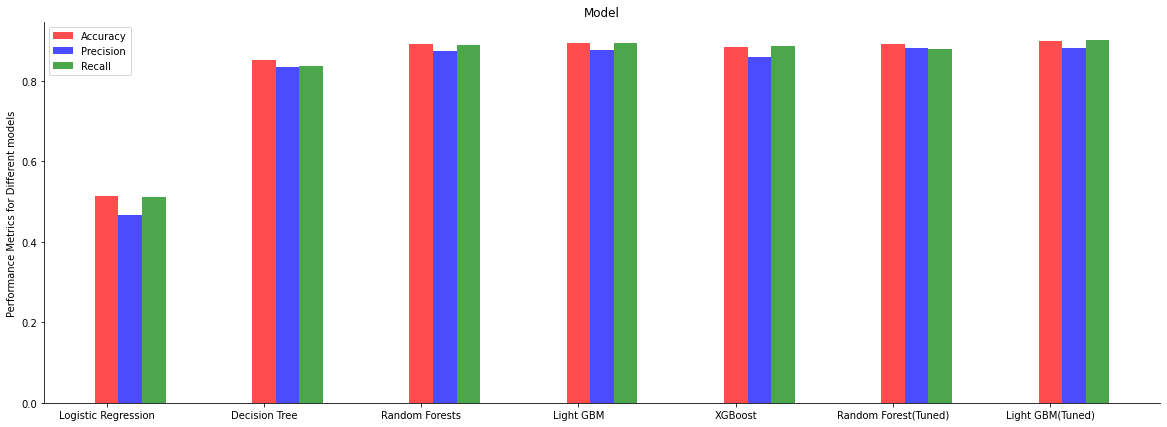

In [73]:
plt.figure(figsize=(20, 7))
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests', 'Light GBM', 'XGBoost', 'Random Forest(Tuned)', 'Light GBM(Tuned)']
values = [accuracy_logit, accuracy_dtree, accuracy_rf, accuracy_lgbm, accuracy_xg, accuracy_rf_opt, accuracy_lgbm_opt]
model = np.arange(len(models))

plt.bar(model, values, align='center', width = 0.15, alpha=0.7, color = 'red', label= 'Accuracy')
plt.xticks(model, models)
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests', 'Light GBM', 'XGBoost', 'Random Forest(Tuned)', 'Light GBM(Tuned)']
values = [precision_logit, precision_dtree, precision_rf, precision_lgbm, precision_xg, precision_rf_opt, precision_lgbm_opt]
model = np.arange(len(models))

plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'Precision')
plt.xticks(model, models)
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests', 'Light GBM', 'XGBoost', 'Random Forest(Tuned)', 'Light GBM(Tuned)']
values = [recall_logit, recall_dtree, recall_rf, recall_lgbm, recall_xg, recall_rf_opt, recall_lgbm_opt]
model = np.arange(len(models))

plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'green', label = 'Recall')
plt.xticks(model, models)

plt.ylabel('Performance Metrics for Different models')
plt.title('Model')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.show()    

- Based on the comparisons and the key meteric - Recall, <b>Light GBM</b> Perfroms the best with Recall value of 90%. Hence we choose our final model as Light GBM

## If there were other variables also in the data:
### 1. Model building would definitely include the most important features identified such as Chronic_kidney_disease and Adrenal_and_thyroid_disorders
### 2. A greater understanding of the problem can allow more feature engineering to be performed using information and papers available online. As an example - Haemoglobin levels show significant negative correlation with age, pregnancy, and gender, which can be used in feature engineering to predict BP abnormalities.